# Yelp Dataset

Yelp is hosting a challenge using a dataset of 10 cities and their businesses.
- U.K.: Edinburgh
- Germany: Karlsruhe
- Canada: Montreal and Waterloo
- U.S.: Pittsburgh, Charlotte, Urbana-Champaign, Phoenix, Las Vegas, Madison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import time

%matplotlib inline
plt.style.use("ggplot")

# What Makes Coffee & Tea Businesses Successful?

## 1. Creating Data Frame for Coffee & Tea Businesses

In this part of the code, the business JSON dataset is used to select all businesses that were coffee and tea shops.

In [2]:
# Getting yelp dataset files
def get_json_data(directory):
    # opening file
    file = open(directory, "r")
    
    data = []
    for business in file:
        data.append(json.loads(business))
    
    file.close()
    return data

In [3]:
business_data = get_json_data("/data/yelp/yelp_academic_dataset_business.json")

In [4]:
types = {}
for business in business_data:
    categories = business["categories"]
    for category in categories:
        if category in types:
            types[category] += 1
        else:
            types[category] = 1

In [5]:
coffee_tea_data = []

for business in business_data:
    categories = business["categories"]
    if "Coffee & Tea" in categories:
        coffee_tea_data.append(business)

In [6]:
# Getting particular data from business dataset

coffee_tea_dict = {
    "Name": [],
    "Accepts Credit Cards": [],
    "Wi-Fi": [],
    "Price Range": [],
    "Stars": [],
    "Review Count": [],
    "Days Open": [],
    "City": [],
    "State": [],
    "Business ID": [],
    "Outdoor Seating": [],
    "Categories": []
}

# Getting name, accepts credit cards, price range, stars, review count, days open, city, wi-fi, business ID, outdoor seating
for business in coffee_tea_data:
    coffee_tea_dict["Name"].append(business["name"])
    if "Accepts Credit Cards" in business["attributes"]: 
        coffee_tea_dict["Accepts Credit Cards"].append(business["attributes"]["Accepts Credit Cards"])
    else:
        coffee_tea_dict["Accepts Credit Cards"].append(np.nan)
    if "Wi-Fi" in business["attributes"]: 
        coffee_tea_dict["Wi-Fi"].append(business["attributes"]["Wi-Fi"])
    else:
        coffee_tea_dict["Wi-Fi"].append(np.nan)
    if "Price Range" in business["attributes"]: 
        coffee_tea_dict["Price Range"].append(business["attributes"]["Price Range"])
    else:
        coffee_tea_dict["Price Range"].append(np.nan)
    coffee_tea_dict["Stars"].append(business["stars"])
    coffee_tea_dict["Review Count"].append(business["review_count"])
    coffee_tea_dict["Days Open"].append(len(business["hours"]))
    coffee_tea_dict["City"].append((business["city"]))
    coffee_tea_dict["State"].append((business["state"]))
    coffee_tea_dict["Business ID"].append((business["business_id"]))
    if "Outdoor Seating" in business["attributes"]: 
        coffee_tea_dict["Outdoor Seating"].append(business["attributes"]["Outdoor Seating"])
    else:
        coffee_tea_dict["Outdoor Seating"].append(np.nan)
    categories = business["categories"]
    categories.remove("Coffee & Tea")
    coffee_tea_dict["Categories"].append(categories)

In [7]:
review_file = open("/data/yelp/yelp_academic_dataset_review.json", "r")

In [8]:
review_dict = {
    "Business ID": [],
    "Stars": []
}

for review in review_file:
    json_data = json.loads(review)
    
    review_dict["Business ID"].append(json_data["business_id"])
    review_dict["Stars"].append(json_data["stars"])
    
review_file.close()

In [9]:
review_df = pd.DataFrame(review_dict)
review_to_merge_df = review_df.groupby("Business ID")[["Stars"]].mean()

In [10]:
review_to_merge_df.columns = ["Actual Stars"]

In [11]:
# Creating data frame
coffee_tea_basic_df = pd.DataFrame(coffee_tea_dict).dropna().set_index("Name")
coffee_tea_df = pd.merge(coffee_tea_basic_df, review_to_merge_df, left_on="Business ID", right_index=True)

## 2. Creating a Custom Ranking System

And since some businesses only have a few reviews, I created an alternative ranking using review counts as a factor.

In [12]:
from scipy.stats import t

# Creating custom rating system
n = coffee_tea_df["Review Count"]
score = coffee_tea_df["Actual Stars"] - t.ppf(.975, n) * 0.3 / (n ** .5)

In [13]:
coffee_tea_df["New Rating"] = score
coffee_tea_df.sort_values(ascending=False, by="New Rating")

,Accepts Credit Cards,Business ID,Categories,City,Days Open,Outdoor Seating,Price Range,Review Count,Stars,State,Wi-Fi,Actual Stars,New Rating
Name,,,,,,,,,,,,,
Crate Coffee Market,True,cxgERbHMIIfw8vo-eTOb-A,"[Food, Cafes, Restaurants]",Maricopa,6,True,1.0,20,5.0,AZ,free,5.000000,4.860069
Desert Wind Coffee Roasters,True,2T3IYR2rj99r5yWLNt65UA,[Food],Las Vegas,6,False,1.0,61,5.0,NV,free,4.925926,4.849118
Kiwi Juice Bar,True,f7XzrOaFpXfTp6jiTSubMQ,"[Food, Vitamins & Supplements, Juice Bars & Sm...",Chandler,7,False,1.0,14,5.0,AZ,no,5.000000,4.828034
Superstition Coffee,True,0lfA2GcxcvdhvVKvVXN40w,[Food],Queen Creek,0,True,1.0,30,5.0,AZ,free,4.925926,4.814066
Dr. Kaffee,False,9jSE6VWYhI_4NRwoXRQQ4w,"[Food, Cafes, Restaurants]",Karlsruhe,7,True,1.0,12,5.0,BW,free,5.000000,4.811309
TeeGschwendner Isabel Andony,True,HysgvS37Z-XMqL2G9FmsQQ,"[Shopping, Food, Tea Rooms, Gift Shops, Flower...",Karlsruhe,0,False,2.0,11,5.0,BW,no,5.000000,4.800913
Jolly Beans Cafe - Inspirada,True,9tfIK0NYqhv_4mvdqkqTnQ,"[Food, Bakeries]",Henderson,7,True,1.0,11,5.0,NV,free,5.000000,4.800913
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Espresso Royale,True,Eoq2H5z2iQHr6uCdIY6IIg,"[Food, Bagels]",Urbana,7,False,2.0,4,2.0,IL,free,1.750000,1.333533


## 3. Comparing Groups of Coffee & Tea Shops

I am trying to find out if a particular factor affects the rating of each shop.

### 3A. Price Range

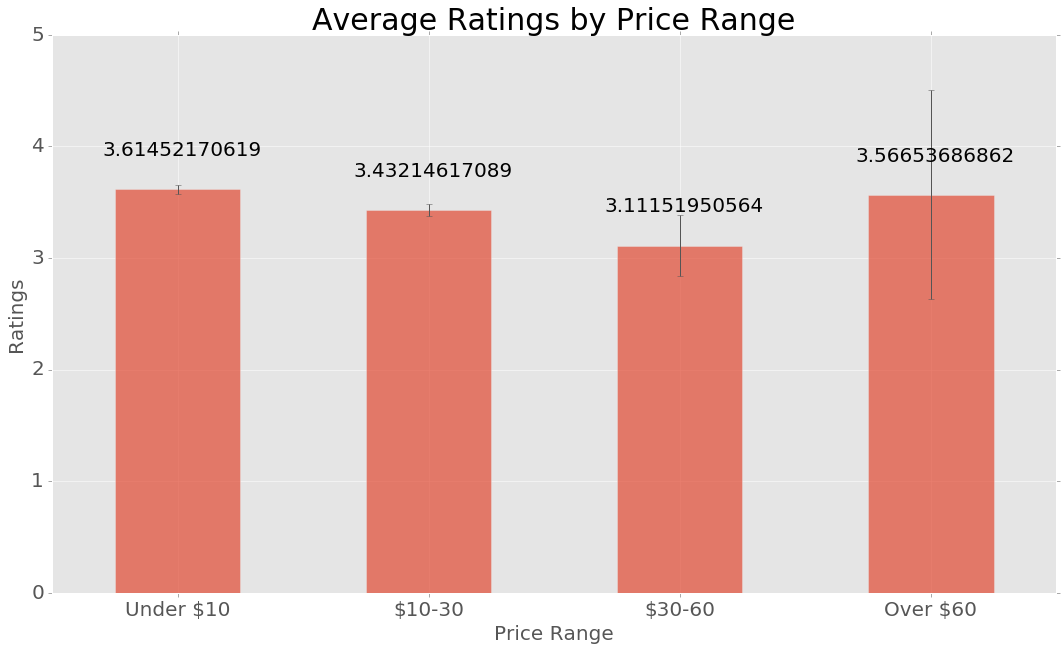

In [14]:
avgPriceRatings = coffee_tea_df.groupby("Price Range")["New Rating"]

# Getting mean and standard error
means = avgPriceRatings.mean()
n = avgPriceRatings.count()
stderrs = t.ppf(.975, n) * avgPriceRatings.std() / (n ** .5)

# Plotting bar graph
ax = means.plot.bar(yerr=stderrs, alpha=.7, figsize=(18,10))
plt.xlabel("Price Range", fontsize=20)
plt.ylabel("Ratings", fontsize=20)
plt.title("Average Ratings by Price Range", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Setting x-value tick labels
ax.set_xticklabels(["Under $10", "$10-30", "$30-60", "Over $60"])
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

# Setting y-value labels
labels = list(means)        
for i, v in enumerate(labels):
    ax.text(i - 0.30, v + 0.30, str(v), color='black', fontsize=20)

In [15]:
def lower_bound(x):
    n = x.count()
    return x.mean() - t.ppf(0.975, n - 1) * x.std() / np.sqrt(n)
    
def upper_bound(x):
    n = x.count()
    return x.mean() + t.ppf(0.975, n - 1) * x.std() / np.sqrt(n) 

coffee_tea_df.groupby("Price Range")["New Rating"].agg([lower_bound, upper_bound, np.mean])

,lower_bound,upper_bound,mean
Price Range,,,
1.0,3.570941,3.658102,3.614522
2.0,3.378168,3.486124,3.432146
3.0,2.840060,3.382979,3.111520
4.0,2.597622,4.535452,3.566537


At under 10 dollars, coffee & tea shops have significantly higher average ratings than those in price ranges (10-30) and (30-60) dollars.

At price range 4, since the 95% confidence interval encompass all the other group's confidence intervals, we can not draw conclusions on its relationship between its ratings with other price ranges.

### 3B. Wi-Fi Availability

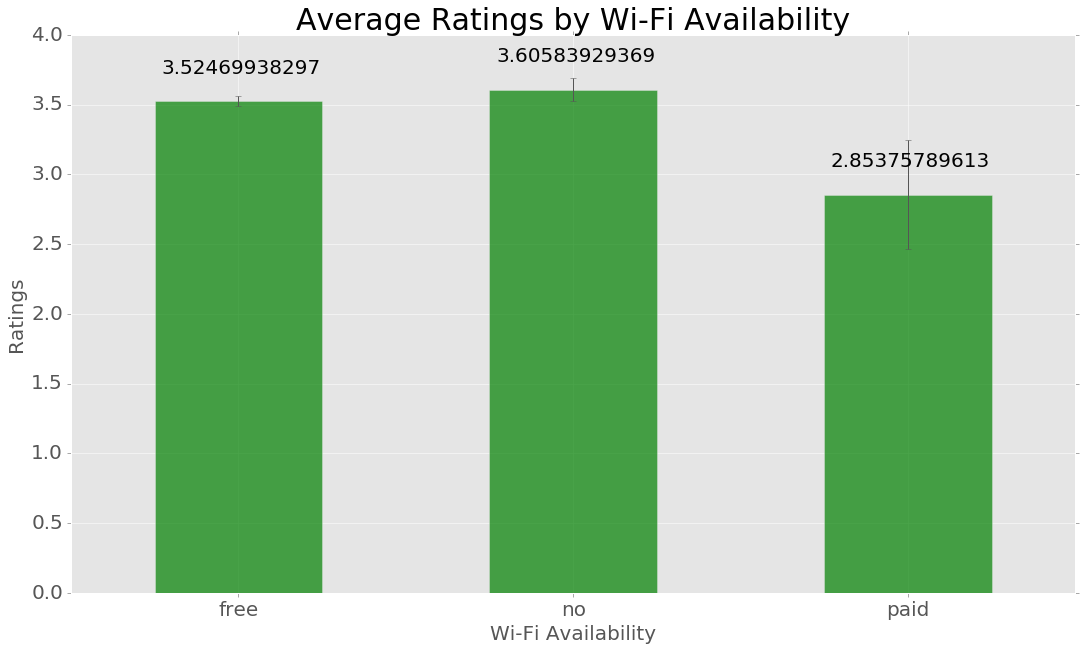

In [16]:
avgWiFiRatings = coffee_tea_df.groupby("Wi-Fi")["New Rating"]

# Getting mean and standard error
means = avgWiFiRatings.mean()
n = avgWiFiRatings.count()
stderrs = t.ppf(.975, n) * avgWiFiRatings.std() / (n ** .5)

# Plotting bar graph
ax = means.plot.bar(yerr=stderrs, alpha=.7, figsize=(18,10), color="g")
plt.xlabel("Wi-Fi Availability", fontsize=20)
plt.ylabel("Ratings", fontsize=20)
plt.title("Average Ratings by Wi-Fi Availability", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Setting x-value tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

# Setting y-value labels
labels = list(means)        
for i, v in enumerate(labels):
    ax.text(i - 0.23, v + 0.20, str(v), color='black', fontsize=20)

In [17]:
coffee_tea_df.groupby("Wi-Fi")["New Rating"].agg([lower_bound, upper_bound, np.mean])

,lower_bound,upper_bound,mean
Wi-Fi,,,
free,3.487470,3.561929,3.524699
no,3.523400,3.688279,3.605839
paid,2.462176,3.245340,2.853758


There are no significant difference in average ratings between coffee & tea shops that have free Wi-Fi and shops that do not offer Wi-Fi.

However, coffee & tea shops that require customers to pay for Wi-Fi have significantly lower ratings than the other two groups mentioned earlier.

### 3C. Outdoor Seating

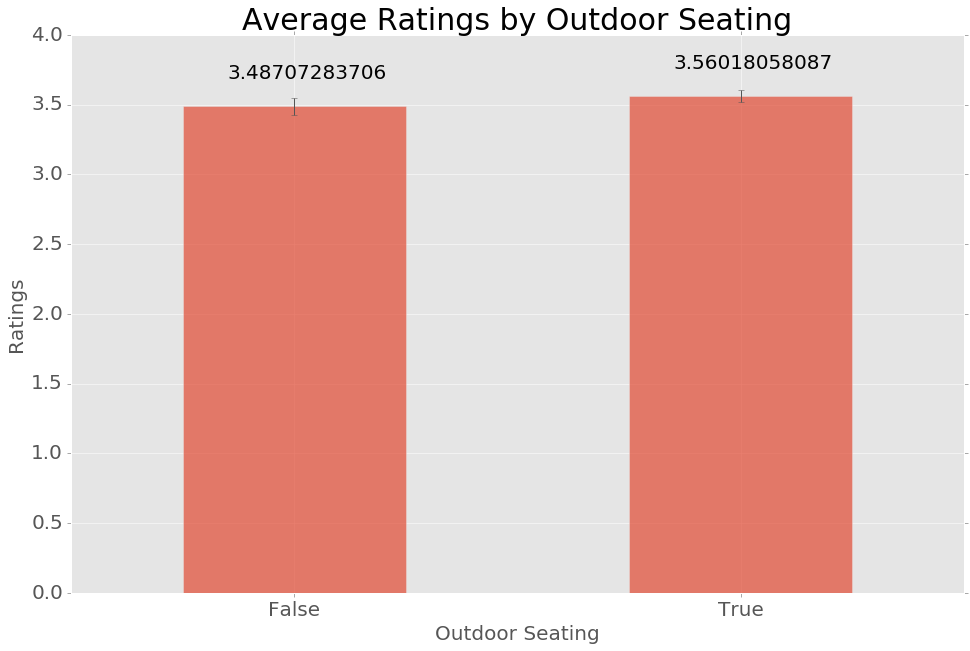

In [18]:
avgOutdoorSeatingRatings = coffee_tea_df.groupby("Outdoor Seating")["New Rating"]

# Getting mean and standard error
means = avgOutdoorSeatingRatings.mean()
n = avgOutdoorSeatingRatings.count()
stderrs = t.ppf(.975, n) * avgOutdoorSeatingRatings.std() / (n ** .5)

# Plotting bar graph
ax = means.plot.bar(yerr=stderrs, alpha=.7, figsize=(16,10))
plt.xlabel("Outdoor Seating", fontsize=20)
plt.ylabel("Ratings", fontsize=20)
plt.title("Average Ratings by Outdoor Seating", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Setting x-value tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

# Setting y-value labels
labels = list(means)        
for i, v in enumerate(labels):
    ax.text(i - 0.15, v + 0.20, str(v), color='black', fontsize=20)

In [19]:
coffee_tea_df.groupby("Outdoor Seating")["New Rating"].agg([lower_bound, upper_bound, np.mean])

,lower_bound,upper_bound,mean
Outdoor Seating,,,
False,3.427082,3.547063,3.487073
True,3.519189,3.601172,3.560181


There is no significant difference in average ratings between coffee & tea shops that do have outdoor seating and those that do not.

## 4. Creating Linear Regression Models to Predict Ratings

In this section, I will be finding the variables that best predicts the custom rating score.

### Model 1: Review Count, Wi-Fi, Price Range (Base)

In [20]:
sub = coffee_tea_df[["Review Count", "Wi-Fi", "Price Range", "New Rating"]]

X = sub[["Review Count"]]
X = pd.concat([X, pd.get_dummies(sub["Wi-Fi"], drop_first=True), pd.get_dummies(sub["Price Range"], drop_first=True)], axis=1)
y = sub["New Rating"]

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [21]:
from sklearn.cross_validation import cross_val_score

# Calculate cross validation error
np.sqrt(-cross_val_score(model, X, y, cv=10, 
                         scoring="mean_squared_error").mean())

0.72041286003675808

### Model 2: Review Count, Wi-Fi, Price Range, State

In [22]:
sub = coffee_tea_df[["Review Count", "Wi-Fi", "Price Range", "New Rating", "State"]]

X = sub[["Review Count"]]
X = pd.concat([X, pd.get_dummies(sub["Wi-Fi"], drop_first=True), pd.get_dummies(sub["Price Range"], drop_first=True), 
               pd.get_dummies(sub["State"], drop_first=True)], axis=1)
y = sub["New Rating"]

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
from sklearn.cross_validation import cross_val_score

# Calculate cross validation error
np.sqrt(-cross_val_score(model, X, y, cv=10, 
                         scoring="mean_squared_error").mean())

0.70597432552133943

### Model 3: Review Count, Wi-Fi, Price Range, City

In [24]:
sub = coffee_tea_df[["Review Count", "Wi-Fi", "Price Range", "New Rating", "City"]]

X = sub[["Review Count"]]
X = pd.concat([X, pd.get_dummies(sub["Wi-Fi"], drop_first=True), pd.get_dummies(sub["Price Range"], drop_first=True), 
               pd.get_dummies(sub["City"], drop_first=True)], axis=1)
y = sub["New Rating"]

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
from sklearn.cross_validation import cross_val_score

# Calculate cross validation error
np.sqrt(-cross_val_score(model, X, y, cv=10, 
                         scoring="mean_squared_error").mean())

494613816.31675184

### Model 4: Review Count, Wi-Fi, Price Range, State, Accepts Credit Cards

In [26]:
sub = coffee_tea_df[["Review Count", "Wi-Fi", "Price Range", "New Rating", "Accepts Credit Cards", "State"]]

X = sub[["Review Count"]]
X = pd.concat([X, pd.get_dummies(sub["Wi-Fi"], drop_first=True), pd.get_dummies(sub["Price Range"], drop_first=True), 
               pd.get_dummies(sub["Accepts Credit Cards"], drop_first=True), pd.get_dummies(sub["State"], drop_first=True)], 
              axis=1)
y = sub["New Rating"]

from sklearn.linear_model import LinearRegression
model = LinearRegression()

model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [27]:
from sklearn.cross_validation import cross_val_score

# Calculate cross validation error
np.sqrt(-cross_val_score(model, X, y, cv=10, 
                         scoring="mean_squared_error").mean())

0.70619142346752839

I used 4 linear regression models to predict the custom ratings. The 1st model consists of the review count, wi-fi, and price range, which has a root mean square (RMS) error of 0.720. The 2nd model added the state of each coffee & tea business as a predictor and it lowered the RMS error to 0.706.

So, for the 3rd model, I decided to use a more precise variable for location (city instead of state). However, because there are over 90 cities and less than 2000 coffee & tea shops, the variation is much larger, causing an extremely large RMS error.

The 4th model added credit card acceptance as a predictor to the custom rating while using the state as the categorical data for location. Adding credit cards did not significantly changed the RMS error (0.706), which is essentially the same as model 2. 

From this analysis, I decide to use model 2 because it has the lowest RMS error and has less predictor variables than model 4.

# Yelp Review Trends

In [28]:
review_file = open("/data/yelp/yelp_academic_dataset_review.json", "r")

num_review_dict = {
    "Date": [],
    "Stars": []
}

for review in review_file:
    json_data = json.loads(review)
    
    num_review_dict["Date"].append(json_data["date"])
    num_review_dict["Stars"].append(json_data["stars"])

review_file.close()

In [29]:
num_review_df = pd.DataFrame(num_review_dict)

In [30]:
review_file = open("/data/yelp/yelp_academic_dataset_review.json", "r")

review_dict = {
    "Stars": [],
    "Score": [],
    "Useful": [],
    "Funny": [],
    "Cool": [],
    "Date": []
}

for data in review_file:
    review = json.loads(data)
    review_dict["Stars"].append(review["stars"])
    review_score = 0
    for value in review["votes"].values():
        review_score += value
    review_dict["Score"].append(review_score)
    review_dict["Useful"].append(review["votes"]["useful"])
    review_dict["Funny"].append(review["votes"]["funny"])
    review_dict["Cool"].append(review["votes"]["cool"])
    review_dict["Date"].append(review["date"])
    
review_file.close()

In [31]:
review_df = pd.DataFrame(review_dict)
review_df.sort_values(by="Score", ascending=False).describe()

,Cool,Funny,Score,Stars,Useful
count,2.225213e+06,2.225213e+06,2.225213e+06,2.225213e+06,2.225213e+06
mean,5.496431e-01,4.412252e-01,2.011880e+00,3.756092e+00,1.021012e+00
std,1.676107e+00,1.539476e+00,4.976205e+00,1.366518e+00,2.120594e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00
max,1.380000e+02,1.420000e+02,4.470000e+02,5.000000e+00,1.670000e+02


## 1. Finding Patterns in Weekdays

In [32]:
import datetime

num_review_df["Date"] = pd.to_datetime(num_review_df["Date"])
num_review_df["Day of Week"] = num_review_df["Date"].dt.dayofweek
num_review_df["Month"] = num_review_df["Date"].dt.month

In [33]:
days_of_week = ["Mon.", "Tues.", "Wed.", "Thur.", "Fri.", "Sat.", "Sun."]
months = ["Jan.", "Feb.", "Mar.", "Apr.", "May", "June", "July", "Aug.", "Sept.", "Oct.", "Nov.", "Dec."]

In [34]:
review_day_of_week = num_review_df.groupby("Day of Week").agg([np.mean, np.size, np.std]).get("Stars")
means = round(review_day_of_week["mean"], 5)
counts = review_day_of_week["size"]
stderrs = t.ppf(.975, counts) * review_day_of_week["std"] / (counts ** .5)

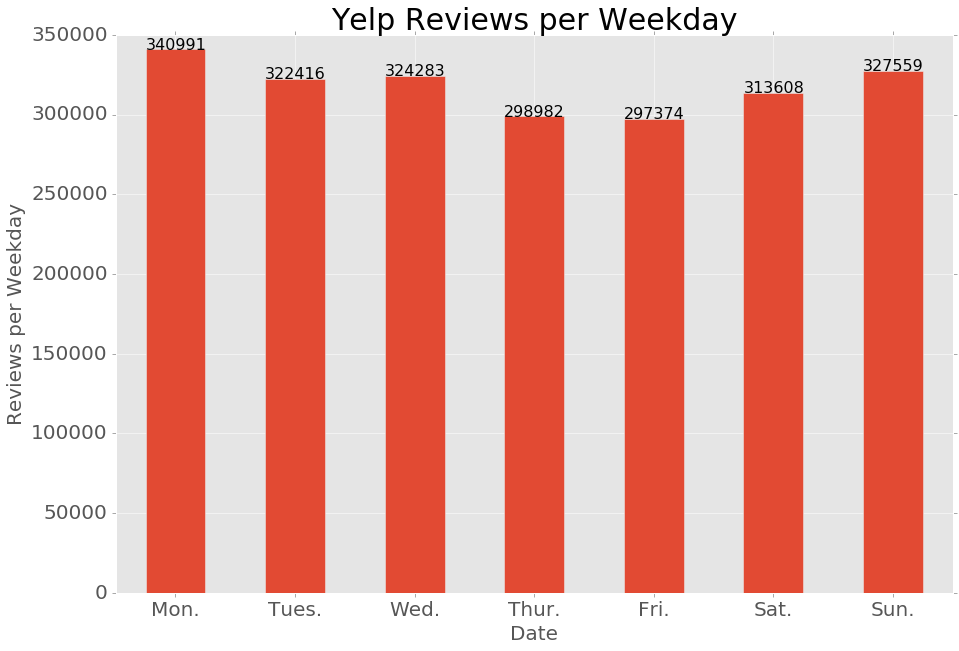

In [35]:
ax = counts.plot.bar(figsize=(15,10))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Reviews per Weekday", fontsize=20)
plt.title("Yelp Reviews per Weekday", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Setting x-value tick labels
ax.set_xticklabels(days_of_week)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
    
# Setting y-value labels
labels = list(counts)        
for i, v in enumerate(counts):
    ax.text(i - 0.25, v + 0.20, str(v), color='black', fontsize=16)

Monday contains the highest number of Yelp reviews while Thursday and Friday contain the least number of Yelp reviews.

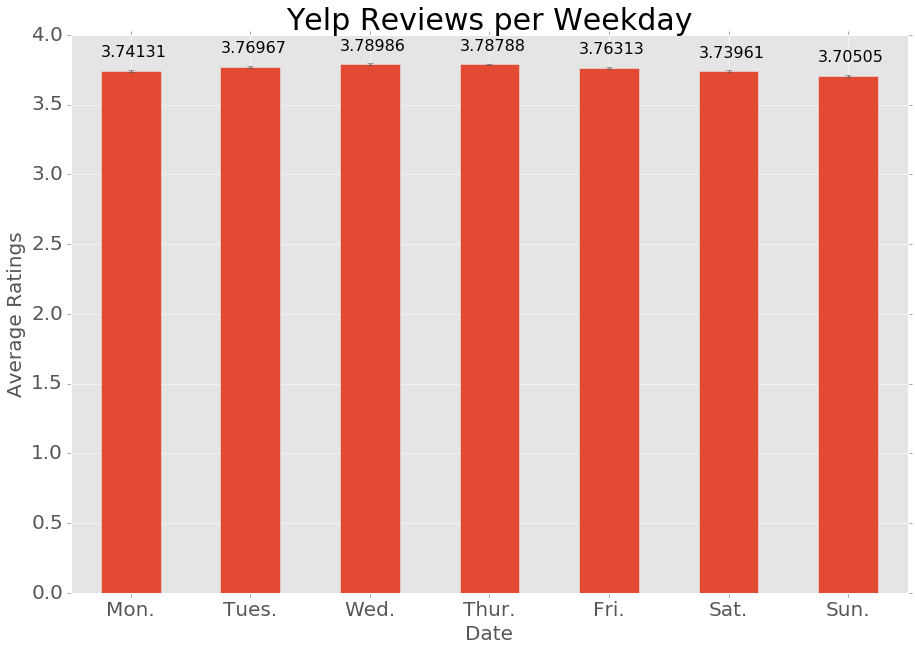

In [36]:
ax = means.plot.bar(yerr=stderrs, figsize=(15,10))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Average Ratings", fontsize=20)
plt.title("Yelp Reviews per Weekday", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Setting x-value tick labels
ax.set_xticklabels(days_of_week)
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
    
# Setting y-value labels
labels = list(means)        
for i, v in enumerate(means):
    ax.text(i - 0.25, v + 0.10, str(v), color='black', fontsize=16)

In [37]:
num_review_df.groupby("Day of Week").agg([np.mean, lower_bound, upper_bound]).get("Stars")

,mean,lower_bound,upper_bound
Day of Week,,,
0,3.741310,3.736767,3.745852
1,3.769673,3.765005,3.774342
2,3.789863,3.785217,3.794509
3,3.787880,3.783004,3.792757
4,3.763130,3.758166,3.768094
5,3.739611,3.734738,3.744484
6,3.705055,3.700345,3.709765


Wednesday and Thursday tend to have the highest average Yelp rating.

In [38]:
reviews_per_day = num_review_df.groupby("Date")["Stars"].count()

## 2. General Trend in Yelp Reviews

(array([    0.,   500.,  1000.,  1500.,  2000.,  2500.]),
 <a list of 6 Text yticklabel objects>)

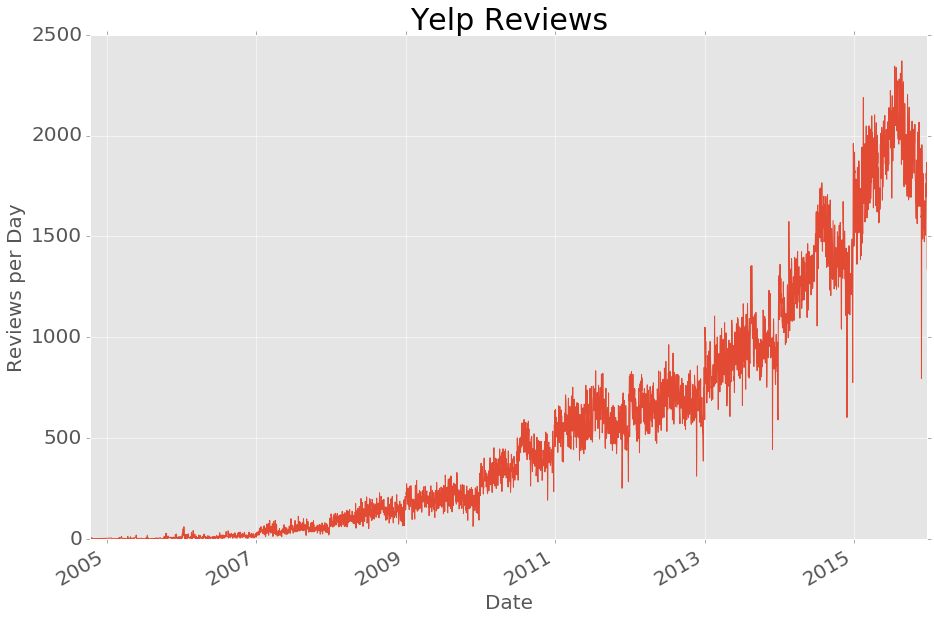

In [39]:
reviews_per_day.plot(figsize=(15,10))
plt.xlabel("Date", fontsize=20)
plt.ylabel("Reviews per Day", fontsize=20)
plt.title("Yelp Reviews", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

General increase in number of reviews with a spike in reviews each summer starting in 2011.

In [40]:
score = review_df.groupby("Score")["Date"].count()

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.]),
 <a list of 8 Text yticklabel objects>)

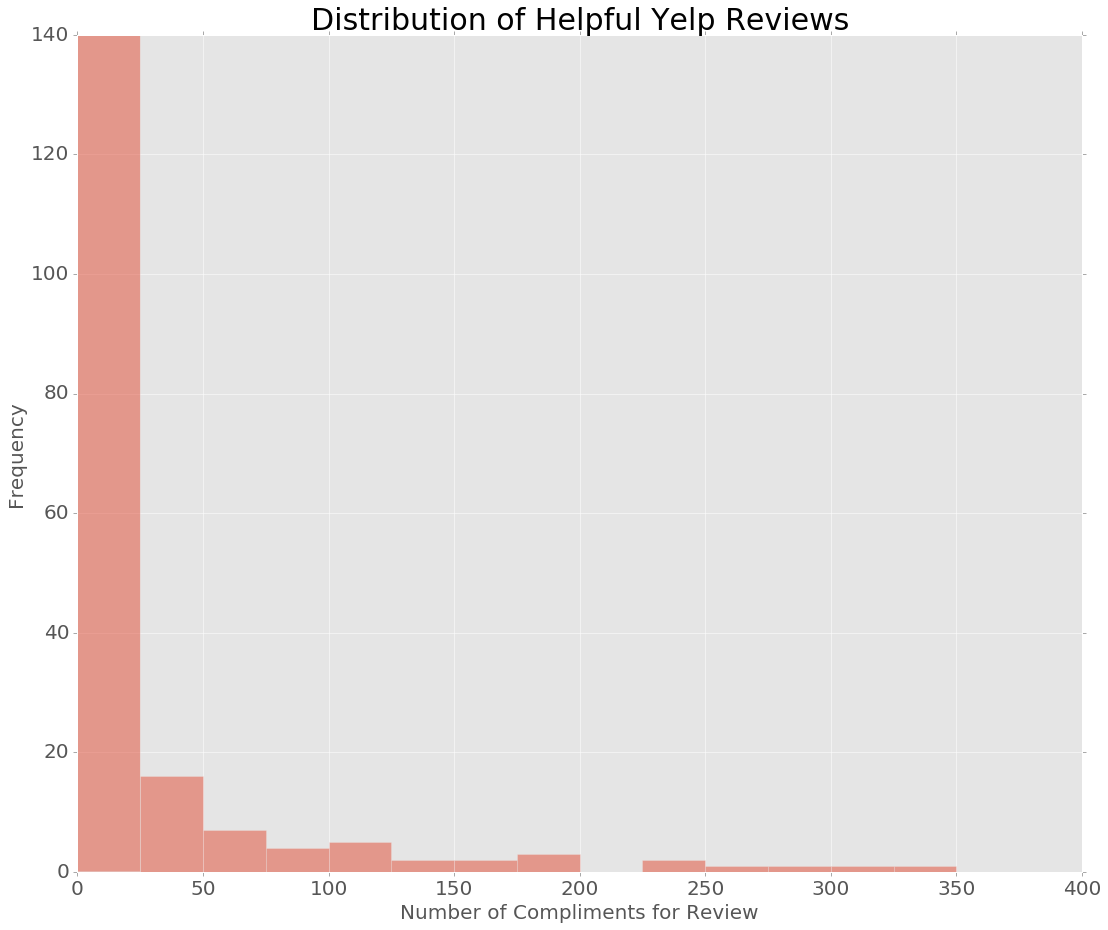

In [41]:
score.hist(alpha=.5, bins=range(0, 400, 25), figsize=(18,15))
plt.xlabel("Number of Compliments for Review", fontsize=20)
plt.ylabel("Frequency", fontsize=20)
plt.title("Distribution of Helpful Yelp Reviews", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

Skewed right distribution of the number of helpful reviews.